<a href="https://colab.research.google.com/github/mitkrieg/citibike-timeseries/blob/main/var_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
from fbprophet import Prophet
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [3]:
# Import PyDrive and associated libraries.
# This only needs to be done once per notebook.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [4]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/MyDrive/Flatiron/Capstone/
%ls

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/MyDrive/Flatiron/Capstone
'Citibike Re-Balancing.gslides'   fbprophet_model.ipynb   starts.pickle
 cleaning.py                      historical.pickle       station_mat.pickle
 data/                            live.pickle             station.py
 ends.pickle                      __pycache__/            trips.pickle


In [4]:
year_2018 = pickle.load(open('/gdrive/MyDrive/Flatiron/Capstone/historical.pickle','rb'))

In [5]:
station_mat = year_2018.avail_bikes.swaplevel().unstack().resample('H').mean()

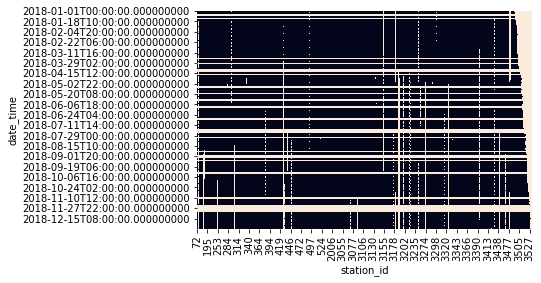

In [6]:
sns.heatmap(station_mat.isnull(),cbar=False)

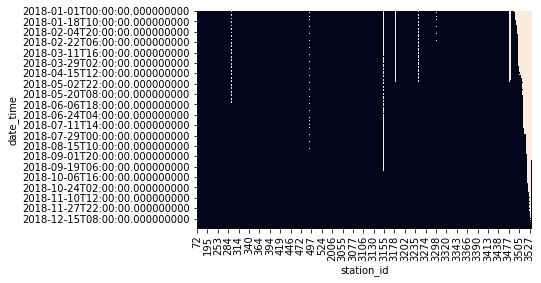

In [ ]:
station_mat = station_mat.interpolate()
sns.heatmap(station_mat.isnull(),cbar=False)

In [ ]:
station_drop = list(station_mat.isna().sum().sort_values(ascending=False).head(45).index)
station_mat.drop(columns=station_drop,inplace=True)

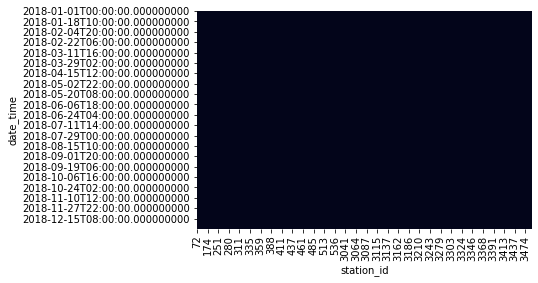

In [ ]:
sns.heatmap(station_mat.isnull(),cbar=False)

In [ ]:
station_mat.columns = [str(col) for col in station_mat.columns]
station_mat.head()

,72,79,82,83,116,119,120,127,128,143,144,146,150,151,152,157,161,164,167,168,173,174,195,212,216,217,223,228,229,232,236,237,238,239,241,242,243,244,245,247,...,3429,3430,3431,3434,3435,3436,3437,3438,3440,3443,3447,3449,3452,3453,3454,3455,3456,3457,3458,3459,3461,3462,3463,3466,3467,3469,3472,3474,3476,3477,3478,3481,3486,3489,3490,3491,3492,3493,3494,3495
date_time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00,13.0,4.0,3.0,30.0,0.0,12.0,7.0,5.0,10.5,12.5,4.0,15.0,8.0,3.0,6.0,8.0,3.5,0.0,7.0,17.0,0.0,6.0,10.0,9.0,7.0,18.0,0.0,7.0,13.0,10.0,6.0,19.5,4.0,7.0,10.0,7.0,20.0,10.5,7.0,4.0,...,23.5,1.0,6.0,23.0,1.0,0.0,23.0,10.0,11.0,0.0,22.5,5.0,1.0,9.0,9.0,10.0,4.0,0.0,0.0,12.0,0.0,4.0,22.0,18.0,14.0,1.0,11.0,0.0,0.0,15.0,16.0,7.0,14.0,5.0,5.0,13.0,16.0,11.0,17.0,20.0
2018-01-01 01:00:00,13.0,4.0,4.0,30.0,0.0,12.0,7.0,3.0,9.0,13.0,4.0,15.0,9.0,3.0,5.0,9.0,4.0,0.0,7.0,14.0,0.0,7.0,9.0,9.0,7.0,18.0,0.0,7.0,14.0,10.0,4.0,20.0,4.0,7.0,10.0,7.0,20.0,11.0,7.0,5.0,...,24.0,1.0,5.0,23.0,1.0,0.0,0.0,10.0,11.0,0.0,22.0,5.0,1.0,9.0,9.0,10.0,4.0,0.0,0.0,12.0,0.0,4.0,22.0,18.0,14.0,1.0,11.0,0.0,0.0,15.0,16.0,7.0,14.0,5.0,5.0,13.0,16.0,11.0,17.0,20.0
2018-01-01 02:00:00,13.0,4.0,4.0,30.0,0.0,12.0,7.0,3.0,9.0,13.0,4.0,14.0,9.0,2.0,5.0,9.0,4.0,0.0,8.0,12.0,0.0,8.0,9.5,9.0,7.0,19.0,0.0,7.0,13.0,10.0,4.0,20.0,3.5,7.0,10.0,7.0,20.0,11.5,7.0,5.0,...,24.0,1.0,7.5,23.0,1.0,0.0,0.0,10.0,10.0,0.0,22.0,5.0,1.0,8.0,9.0,10.0,4.0,0.0,0.0,12.0,1.0,4.0,23.0,18.0,14.0,1.0,11.0,0.0,0.0,15.0,16.0,7.0,14.0,5.0,5.0,13.0,16.0,11.0,17.0,20.0
2018-01-01 03:00:00,13.0,4.0,4.0,30.0,0.0,12.0,7.0,5.0,9.0,13.0,4.0,14.0,9.0,0.5,5.0,9.0,3.0,7.5,8.0,12.0,0.0,10.0,10.5,9.0,7.0,19.0,0.0,7.0,13.0,10.0,4.0,20.0,3.0,7.0,10.0,7.0,20.0,12.0,7.0,5.0,...,24.0,1.0,8.0,23.0,2.0,0.0,0.0,10.0,10.0,0.0,22.0,5.0,1.0,7.5,9.0,10.0,4.0,0.0,0.0,13.0,2.0,4.0,23.0,17.5,14.0,1.0,11.0,0.0,0.0,15.0,16.0,6.5,14.0,5.0,5.0,13.0,16.0,11.5,17.0,20.0
2018-01-01 04:00:00,13.0,4.0,4.0,30.0,0.0,12.0,7.0,5.0,9.0,13.0,4.0,14.0,9.0,1.0,5.0,9.0,3.0,15.0,8.0,13.0,0.0,9.0,10.0,9.0,7.0,19.0,0.0,7.0,13.0,10.0,4.0,20.0,4.0,6.0,10.0,7.0,20.0,12.0,7.0,2.0,...,24.0,1.0,9.0,23.0,2.0,0.0,0.0,10.0,10.0,0.0,22.0,5.0,1.0,7.0,9.0,11.0,4.0,0.0,0.0,13.0,2.0,4.0,23.0,17.0,13.0,1.0,11.0,0.0,0.0,15.0,16.0,6.0,14.0,5.0,5.0,13.0,16.0,12.0,17.0,20.0


In [ ]:
import statsmodels as sm
from statsmodels.tsa import vector_ar
from statsmodels.tsa.stattools import adfuller

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [ ]:
def dickey_fuller(ts):
        dftest = adfuller(ts)

        # Extract and display test results
        dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
        for key,value in dftest[4].items():
            dfoutput['Critical Value (%s)'%key] = value
    
        print ('Dickey-Fuller test: \n')
        print(dfoutput)
        
        if dfoutput['p-value'] < .05:
            print(f'\nStationary: p-value {dfoutput["p-value"]} < 0.05\n')
            return True
        else:
           print(f'\nNot Stationary: p-value {dfoutput["p-value"]} > 0.05\n')
           return False



In [ ]:
dickey_results = pd.Series()
for col in station_mat.columns:
  print("Station: ",col)
  dftest = dickey_fuller(station_mat[col])
  dickey_results[col] = dftest

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



Station:  72
Dickey-Fuller test: 

Test Statistic                -1.007571e+01
p-value                        1.225422e-17
#Lags Used                     2.800000e+01
Number of Observations Used    8.731000e+03
Critical Value (1%)           -3.431099e+00
Critical Value (5%)           -2.861871e+00
Critical Value (10%)          -2.566946e+00
dtype: float64

Stationary: p-value 1.2254223457369034e-17 < 0.05

Station:  79
Dickey-Fuller test: 

Test Statistic                -8.187918e+00
p-value                        7.808508e-13
#Lags Used                     3.300000e+01
Number of Observations Used    8.726000e+03
Critical Value (1%)           -3.431100e+00
Critical Value (5%)           -2.861871e+00
Critical Value (10%)          -2.566946e+00
dtype: float64

Stationary: p-value 7.80850809226222e-13 < 0.05

Station:  82
Dickey-Fuller test: 

Test Statistic                   -4.937420
p-value                           0.000029
#Lags Used                       37.000000
Number of Observat

/usr/local/lib/python3.6/dist-packages/statsmodels/regression/linear_model.py:867: RuntimeWarning:

divide by zero encountered in log

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:1294: RuntimeWarning:

invalid value encountered in true_divide



Streaming output truncated to the last 5000 lines.
Stationary: p-value 4.154070897302179e-11 < 0.05

Station:  3056
Dickey-Fuller test: 

Test Statistic                -6.644211e+00
p-value                        5.315843e-09
#Lags Used                     1.700000e+01
Number of Observations Used    8.742000e+03
Critical Value (1%)           -3.431098e+00
Critical Value (5%)           -2.861871e+00
Critical Value (10%)          -2.566946e+00
dtype: float64

Stationary: p-value 5.315842805961496e-09 < 0.05

Station:  3057
Dickey-Fuller test: 

Test Statistic                -8.834440e+00
p-value                        1.734423e-14
#Lags Used                     3.400000e+01
Number of Observations Used    8.725000e+03
Critical Value (1%)           -3.431100e+00
Critical Value (5%)           -2.861871e+00
Critical Value (10%)          -2.566946e+00
dtype: float64

Stationary: p-value 1.7344231172322816e-14 < 0.05

Station:  3058
Dickey-Fuller test: 

Test Statistic                -7.639489

In [ ]:
dickey_results.value_counts()

True     656
False      8
dtype: int64

In [ ]:
investigate = dickey_results.loc[dickey_results == False]
len(investigate)

8

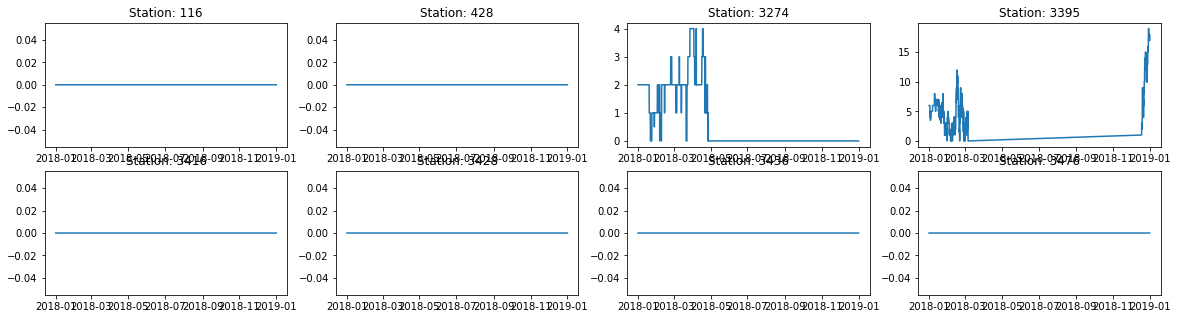

In [ ]:
fig, ax = plt.subplots(ncols=4,nrows=2,figsize=(20,5))

for i, ts in enumerate(investigate.index):
  ax[i//4][i%4].plot(station_mat[ts])
  ax[i//4][i%4].set_title(f'Station: {ts}')

In [ ]:
station_mat.drop(columns=investigate.index,inplace=True)
station_mat.head()

,72,79,82,83,119,120,127,128,143,144,146,150,151,152,157,161,164,167,168,173,174,195,212,216,217,223,228,229,232,236,237,238,239,241,242,243,244,245,247,248,...,3425,3427,3429,3430,3431,3434,3435,3437,3438,3440,3443,3447,3449,3452,3453,3454,3455,3456,3457,3458,3459,3461,3462,3463,3466,3467,3469,3472,3474,3477,3478,3481,3486,3489,3490,3491,3492,3493,3494,3495
date_time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00,13.0,4.0,3.0,30.0,12.0,7.0,5.0,10.5,12.5,4.0,15.0,8.0,3.0,6.0,8.0,3.5,0.0,7.0,17.0,0.0,6.0,10.0,9.0,7.0,18.0,0.0,7.0,13.0,10.0,6.0,19.5,4.0,7.0,10.0,7.0,20.0,10.5,7.0,4.0,4.0,...,3.0,24.0,23.5,1.0,6.0,23.0,1.0,23.0,10.0,11.0,0.0,22.5,5.0,1.0,9.0,9.0,10.0,4.0,0.0,0.0,12.0,0.0,4.0,22.0,18.0,14.0,1.0,11.0,0.0,15.0,16.0,7.0,14.0,5.0,5.0,13.0,16.0,11.0,17.0,20.0
2018-01-01 01:00:00,13.0,4.0,4.0,30.0,12.0,7.0,3.0,9.0,13.0,4.0,15.0,9.0,3.0,5.0,9.0,4.0,0.0,7.0,14.0,0.0,7.0,9.0,9.0,7.0,18.0,0.0,7.0,14.0,10.0,4.0,20.0,4.0,7.0,10.0,7.0,20.0,11.0,7.0,5.0,4.0,...,2.0,23.0,24.0,1.0,5.0,23.0,1.0,0.0,10.0,11.0,0.0,22.0,5.0,1.0,9.0,9.0,10.0,4.0,0.0,0.0,12.0,0.0,4.0,22.0,18.0,14.0,1.0,11.0,0.0,15.0,16.0,7.0,14.0,5.0,5.0,13.0,16.0,11.0,17.0,20.0
2018-01-01 02:00:00,13.0,4.0,4.0,30.0,12.0,7.0,3.0,9.0,13.0,4.0,14.0,9.0,2.0,5.0,9.0,4.0,0.0,8.0,12.0,0.0,8.0,9.5,9.0,7.0,19.0,0.0,7.0,13.0,10.0,4.0,20.0,3.5,7.0,10.0,7.0,20.0,11.5,7.0,5.0,4.0,...,2.0,23.0,24.0,1.0,7.5,23.0,1.0,0.0,10.0,10.0,0.0,22.0,5.0,1.0,8.0,9.0,10.0,4.0,0.0,0.0,12.0,1.0,4.0,23.0,18.0,14.0,1.0,11.0,0.0,15.0,16.0,7.0,14.0,5.0,5.0,13.0,16.0,11.0,17.0,20.0
2018-01-01 03:00:00,13.0,4.0,4.0,30.0,12.0,7.0,5.0,9.0,13.0,4.0,14.0,9.0,0.5,5.0,9.0,3.0,7.5,8.0,12.0,0.0,10.0,10.5,9.0,7.0,19.0,0.0,7.0,13.0,10.0,4.0,20.0,3.0,7.0,10.0,7.0,20.0,12.0,7.0,5.0,4.0,...,2.5,21.5,24.0,1.0,8.0,23.0,2.0,0.0,10.0,10.0,0.0,22.0,5.0,1.0,7.5,9.0,10.0,4.0,0.0,0.0,13.0,2.0,4.0,23.0,17.5,14.0,1.0,11.0,0.0,15.0,16.0,6.5,14.0,5.0,5.0,13.0,16.0,11.5,17.0,20.0
2018-01-01 04:00:00,13.0,4.0,4.0,30.0,12.0,7.0,5.0,9.0,13.0,4.0,14.0,9.0,1.0,5.0,9.0,3.0,15.0,8.0,13.0,0.0,9.0,10.0,9.0,7.0,19.0,0.0,7.0,13.0,10.0,4.0,20.0,4.0,6.0,10.0,7.0,20.0,12.0,7.0,2.0,4.0,...,3.0,21.0,24.0,1.0,9.0,23.0,2.0,0.0,10.0,10.0,0.0,22.0,5.0,1.0,7.0,9.0,11.0,4.0,0.0,0.0,13.0,2.0,4.0,23.0,17.0,13.0,1.0,11.0,0.0,15.0,16.0,6.0,14.0,5.0,5.0,13.0,16.0,12.0,17.0,20.0


In [5]:
import pickle

In [7]:
pickle_out = open('station_mat.pickle','wb')
pickle.dump(station_mat,pickle_out)
pickle_out.close()

In [6]:
station_mat = pickle.load(open('/content/station_mat.pickle','rb'))

In [7]:
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tools.eval_measures import rmse, aic, meanabs

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [11]:
var_model = VAR(station_mat)
var_results = {'p':[],'aic':[]}

for p in range(7):  
  result = var_model.fit(p, ic='aic')
  var_results['p'].append(p)
  var_results['aic'].append(result.aic)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/vector_ar/var_model.py:2092: RuntimeWarning:

overflow encountered in exp



In [12]:
var_results

{'aic': [1685.289177831974,
  682.2091136089293,
  665.6892406075153,
  652.9762575419118,
  634.6438200808111,
  606.0201182650333,
  559.21803589028],
 'p': [0, 1, 2, 3, 4, 5, 6]}

In [8]:
var_model = VAR(station_mat)
result = var_model.fit(6, ic='aic')

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/vector_ar/var_model.py:2092: RuntimeWarning:

overflow encountered in exp



In [1]:
station_mat

NameError: ignored